In [22]:
# pip install meteostat
# pip install tqdm

SyntaxError: invalid syntax (1822401875.py, line 2)

In [11]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from meteostat import Hourly, Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

tqdm.pandas()

In [2]:
# 1. Load full crime dataset

# crime_df = pd.read_csv("Crimes_-_2001_to_Present_20250410.csv", parse_dates=['Date'], low_memory=False)
crime_df = pd.read_csv("Crimes_-_2001_to_Present_20250410.csv", low_memory=False)
crime_df['Date'] = pd.to_datetime(crime_df['Date'])
crime_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,13311263,JG503434,2022-07-29 03:39:00,023XX S TROY ST,1582,OFFENSE INVOLVING CHILDREN,CHILD PORNOGRAPHY,RESIDENCE,True,False,...,25.0,30.0,17,NaN,NaN,2022,04/18/2024 03:40:59 PM,NaN,NaN,NaN
1,13053066,JG103252,2023-01-03 16:44:00,039XX W WASHINGTON BLVD,2017,NARCOTICS,MANUFACTURE / DELIVER - CRACK,SIDEWALK,True,False,...,28.0,26.0,18,NaN,NaN,2023,01/20/2024 03:41:12 PM,NaN,NaN,NaN
2,11227634,JB147599,2017-08-26 10:00:00,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,False,False,...,42.0,32.0,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,13203321,JG415333,2023-09-06 17:00:00,002XX N Wells st,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,42.0,32.0,14,1174694.0,1901831.0,2023,11/04/2023 03:40:18 PM,41.886018,-87.633938,"(41.886018055, -87.633937881)"
4,13204489,JG416325,2023-09-06 11:00:00,0000X E 8TH ST,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,4.0,32.0,06,1176857.0,1896680.0,2023,11/04/2023 03:40:18 PM,41.871835,-87.626151,"(41.871834768, -87.62615082)"


In [3]:
crime_df = crime_df[['Date', 'Arrest', 'Latitude', 'Longitude', 'Community Area']]
crime_df.dropna(subset=['Date', 'Latitude', 'Longitude'], inplace=True)
crime_df['DateHour'] = crime_df['Date'].dt.floor('h')

In [4]:
# 2. Use full available date range

start = crime_df['DateHour'].min()
end = crime_df['DateHour'].max()

print("Training on full range:", start, "to", end)

Training on full range: 2001-01-01 00:00:00 to 2025-04-01 00:00:00


In [5]:
# 3. Generate hourly grid

all_hours = pd.date_range(start=start, end=end, freq='h')
df_hours = pd.DataFrame({'DateHour': all_hours})

In [6]:
# 4. Pull weather data

station = Point(41.9742, -87.9073)
weather_df = Hourly(station, start, end).fetch().reset_index()
weather_df['DateHour'] = weather_df['time'].dt.floor('h')

In [7]:
# 5. Merge hourly grid + weather

df = df_hours.merge(weather_df, on='DateHour', how='left')

In [8]:
# 6. Add time-based features

df['Hour'] = df['DateHour'].dt.hour
df['DayOfWeek'] = df['DateHour'].dt.dayofweek
df['Month'] = df['DateHour'].dt.month
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

In [9]:
# 7. Label crime hours

crime_hours = set(crime_df['DateHour'])
df['CrimeOccurred'] = df['DateHour'].isin(crime_hours).astype(int)

In [12]:
# 8. Add arrest-based features

crime_df_arrests = crime_df[crime_df['Arrest'] == True].copy()
crime_df_arrests.set_index('DateHour', inplace=True)

def count_recent_arrests(dt):
    return crime_df_arrests[(crime_df_arrests.index >= dt - timedelta(days=7)) & 
                            (crime_df_arrests.index < dt)].shape[0]

def count_repeat_signal(dt):
    return crime_df_arrests[(crime_df_arrests.index >= dt - timedelta(days=30)) & 
                            (crime_df_arrests.index < dt)].shape[0]

# print(" Calculating arrest-based features...") 
# df['RecentArrests'] = df['DateHour'].apply(count_recent_arrests)

print("Calculating Recent Arrests...")
df['RecentArrests'] = df['DateHour'].progress_apply(count_recent_arrests)

# df['RepeatOffenderSignal'] = df['DateHour'].apply(count_repeat_signal)
print("Calculating Repeat Offender Signal...")
df['RepeatOffenderSignal'] = df['DateHour'].progress_apply(count_repeat_signal)

Calculating Recent Arrests...


100%|██████████████████████████████████████████████████████████████████████████| 212545/212545 [51:10<00:00, 69.22it/s]


Calculating Repeat Offender Signal...


100%|██████████████████████████████████████████████████████████████████████████| 212545/212545 [52:09<00:00, 67.93it/s]


In [13]:
# 9. Drop missing weather

df.dropna(subset=['temp', 'prcp', 'wspd'], inplace=True)

In [14]:
# Save the processed dataset for future fast use

df.to_parquet("processed_crime_data.parquet")
print("Saved cleaned data as processed_crime_data.parquet")

Saved cleaned data as processed_crime_data.parquet


In [32]:
# 10. Prepare features and target
features = [
    'Hour', 'DayOfWeek', 'Month', 'IsWeekend',
    'temp', 'rhum', 'prcp', 'snow', 'wspd',
    'RecentArrests', 'RepeatOffenderSignal'
]


# Full dataset
X = df[features]
y = df['CrimeOccurred']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# Train model with class_weight to handle imbalance
clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # 👈 handles imbalance internally
    random_state=42
)
clf.fit(X_train, y_train)



RandomForestClassifier(class_weight='balanced', random_state=42)

In [28]:
# # 11. Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# 12. Train model
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

# clf = RandomForestClassifier(
#     n_estimators=100,
#     class_weight='balanced',  # ← 👈 THIS handles imbalance
#     random_state=42
# )
# clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [33]:
#  Save the trained model

joblib.dump(clf, "crime_predictor_model.pkl")
print("Saved trained model as crime_predictor_model.pkl")

Saved trained model as crime_predictor_model.pkl



 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       1.00      1.00      1.00     51928

    accuracy                           1.00     51932
   macro avg       0.50      0.50      0.50     51932
weighted avg       1.00      1.00      1.00     51932

ROC-AUC Score: 0.9999759282082884


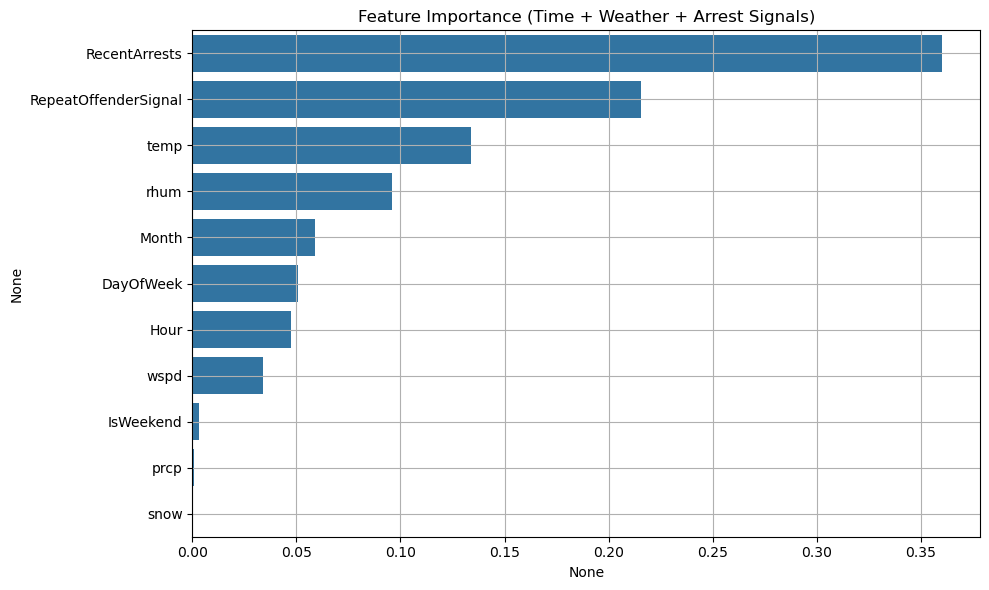

In [34]:
# 13. Evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# 14. Feature importance
feat_imp = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance (Time + Weather + Arrest Signals)")
plt.grid(True)
plt.tight_layout()
plt.show()
